<h4>Tranfer Learning</h4>

<p> Zie <a href="https://www.tensorflow.org/tutorials/images/transfer_learning">LINK</a> voor transfer learning op Tensorflow.

In [54]:
# load Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import datetime
import pickle

In [56]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/tl_mobileNetV2_2/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

<h4>Warning blokker</h4>
<p>De lagen in een model geven een warning. De code hieronder blokced het tonen hiervan.</p>    
    

In [57]:
tf.get_logger().setLevel('ERROR')

In [58]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'
batch_data_dir = '../data/80apples'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
batch_dir = pathlib.Path(batch_data_dir)
edgeFiles = list()
testFiles = list()
batchFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)

for filename in os.listdir(batch_data_dir):
    imgAppleTestDirectory = os.path.join(batch_data_dir)
    testFiles.append(imgAppleTestDirectory) 
    print(batchFiles)    

[]
[]


In [59]:
batch_size = 16
img_size= (224, 224)

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [61]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [62]:
# Test set 

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [63]:
# Predict batch set 

batch_ds = tf.keras.utils.image_dataset_from_directory(
  batch_dir,
  seed=123,
  shuffle=False,
  image_size=img_size,
  batch_size=batch_size)

Found 80 files belonging to 1 classes.


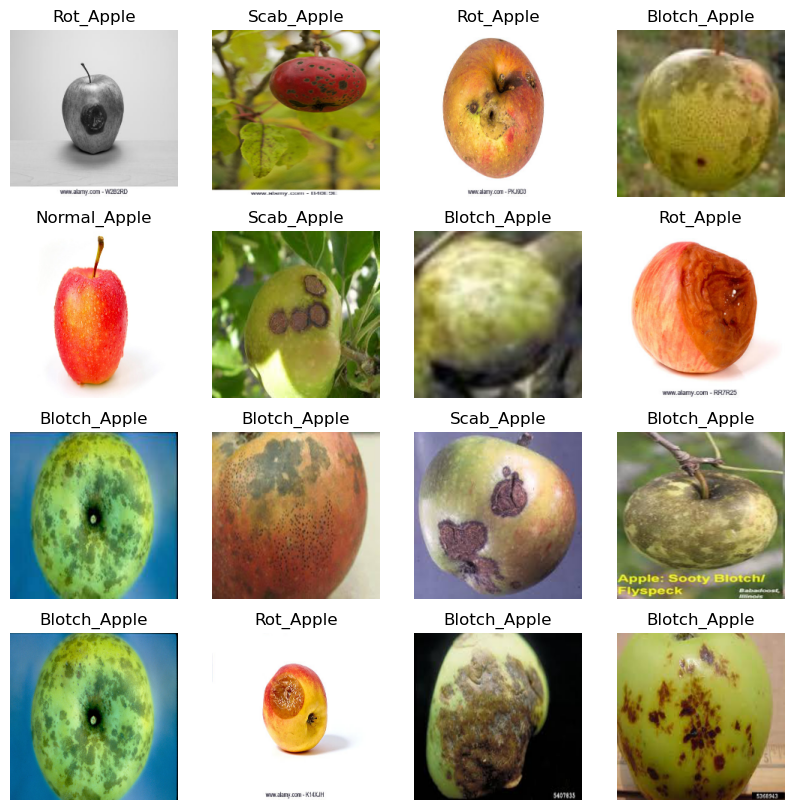

In [64]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [65]:
# confic dataset for performence 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [66]:
# add augmentation
img_height = 224
img_width = 224

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
  layers.RandomZoom(0.6),  
])

In [67]:
# augmentation toegevoegen
image, label = next(iter(train_ds))
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<h4>Base Mobel</h4>
<p>Hier wordt het voorgetrainde model ingeladen</p>

In [68]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [69]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [70]:
image_batch, label_batch =  next(iter(train_ds))
feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [71]:
#Freeze the convolutional base
base_model.trainable = False

<h4>Classification head</h4>

In [72]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [73]:
prediction_layer = tf.keras.layers.Dense(4, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [74]:
#base model architecture
# base_model.summary()

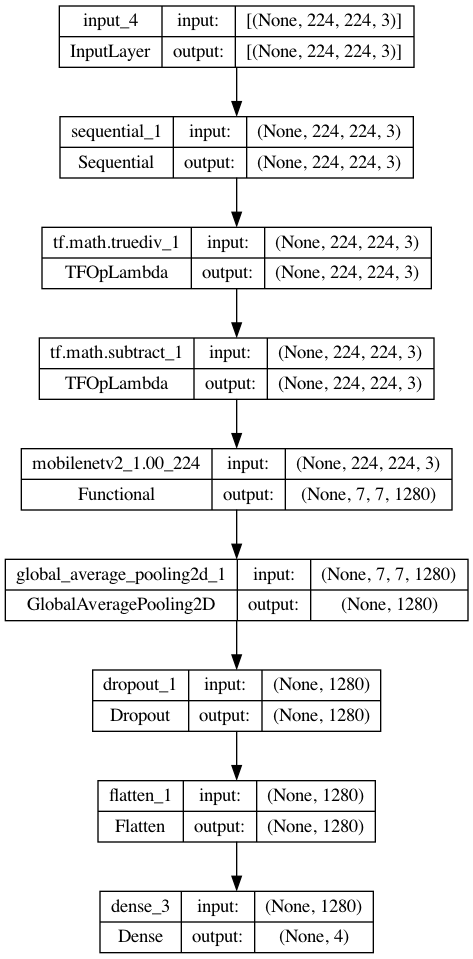

In [75]:
num_classes = 4
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
outputs = prediction_layer(x)
preds=Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs=preds)
keras.utils.plot_model(model, show_shapes=True)

In [76]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_4
1 sequential_1
2 tf.math.truediv_1
3 tf.math.subtract_1
4 mobilenetv2_1.00_224
5 global_average_pooling2d_1
6 dropout_1
7 flatten_1
8 dense_3


<h4>Model</h4>

In [77]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [79]:
len(model.trainable_variables)

2

<h4>Model Training</h4>

In [80]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 3s 250ms/step - loss: 1.6246 - accuracy: 0.2895


In [81]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.62
initial accuracy: 0.29


In [82]:
# add Tensorboard
log_dir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [83]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 1/30
20/20 [==============================] - 15s 444ms/step - loss: 1.9279 - accuracy: 0.2280 - val_loss: 1.4920 - val_accuracy: 0.2368
Epoch 2/30
20/20 [==============================] - 9s 450ms/step - loss: 1.7827 - accuracy: 0.2964 - val_loss: 1.4214 - val_accuracy: 0.2763
Epoch 3/30
20/20 [==============================] - 9s 470ms/step - loss: 1.6469 - accuracy: 0.3257 - val_loss: 1.3683 - val_accuracy: 0.3289
Epoch 4/30
20/20 [==============================] - 10s 473ms/step - loss: 1.5904 - accuracy: 0.3583 - val_loss: 1.3155 - val_accuracy: 0.4474
Epoch 5/30
20/20 [==============================] - 10s 498ms/step - loss: 1.6886 - accuracy: 0.3583 - val_loss: 1.2522 - val_accuracy: 0.5000
Epoch 6/30
20/20 [==============================] - 10s 485ms/step - loss: 1.5096 - accuracy: 0.3681 - val_loss: 1.2009 - val_accuracy: 0.5132
Epoch 7/30
20/20 [==============================] - 10s 500ms/step - loss: 1.4829 - accuracy: 0.4300 - val_loss: 1.1620 - val_accuracy: 0.5526
E

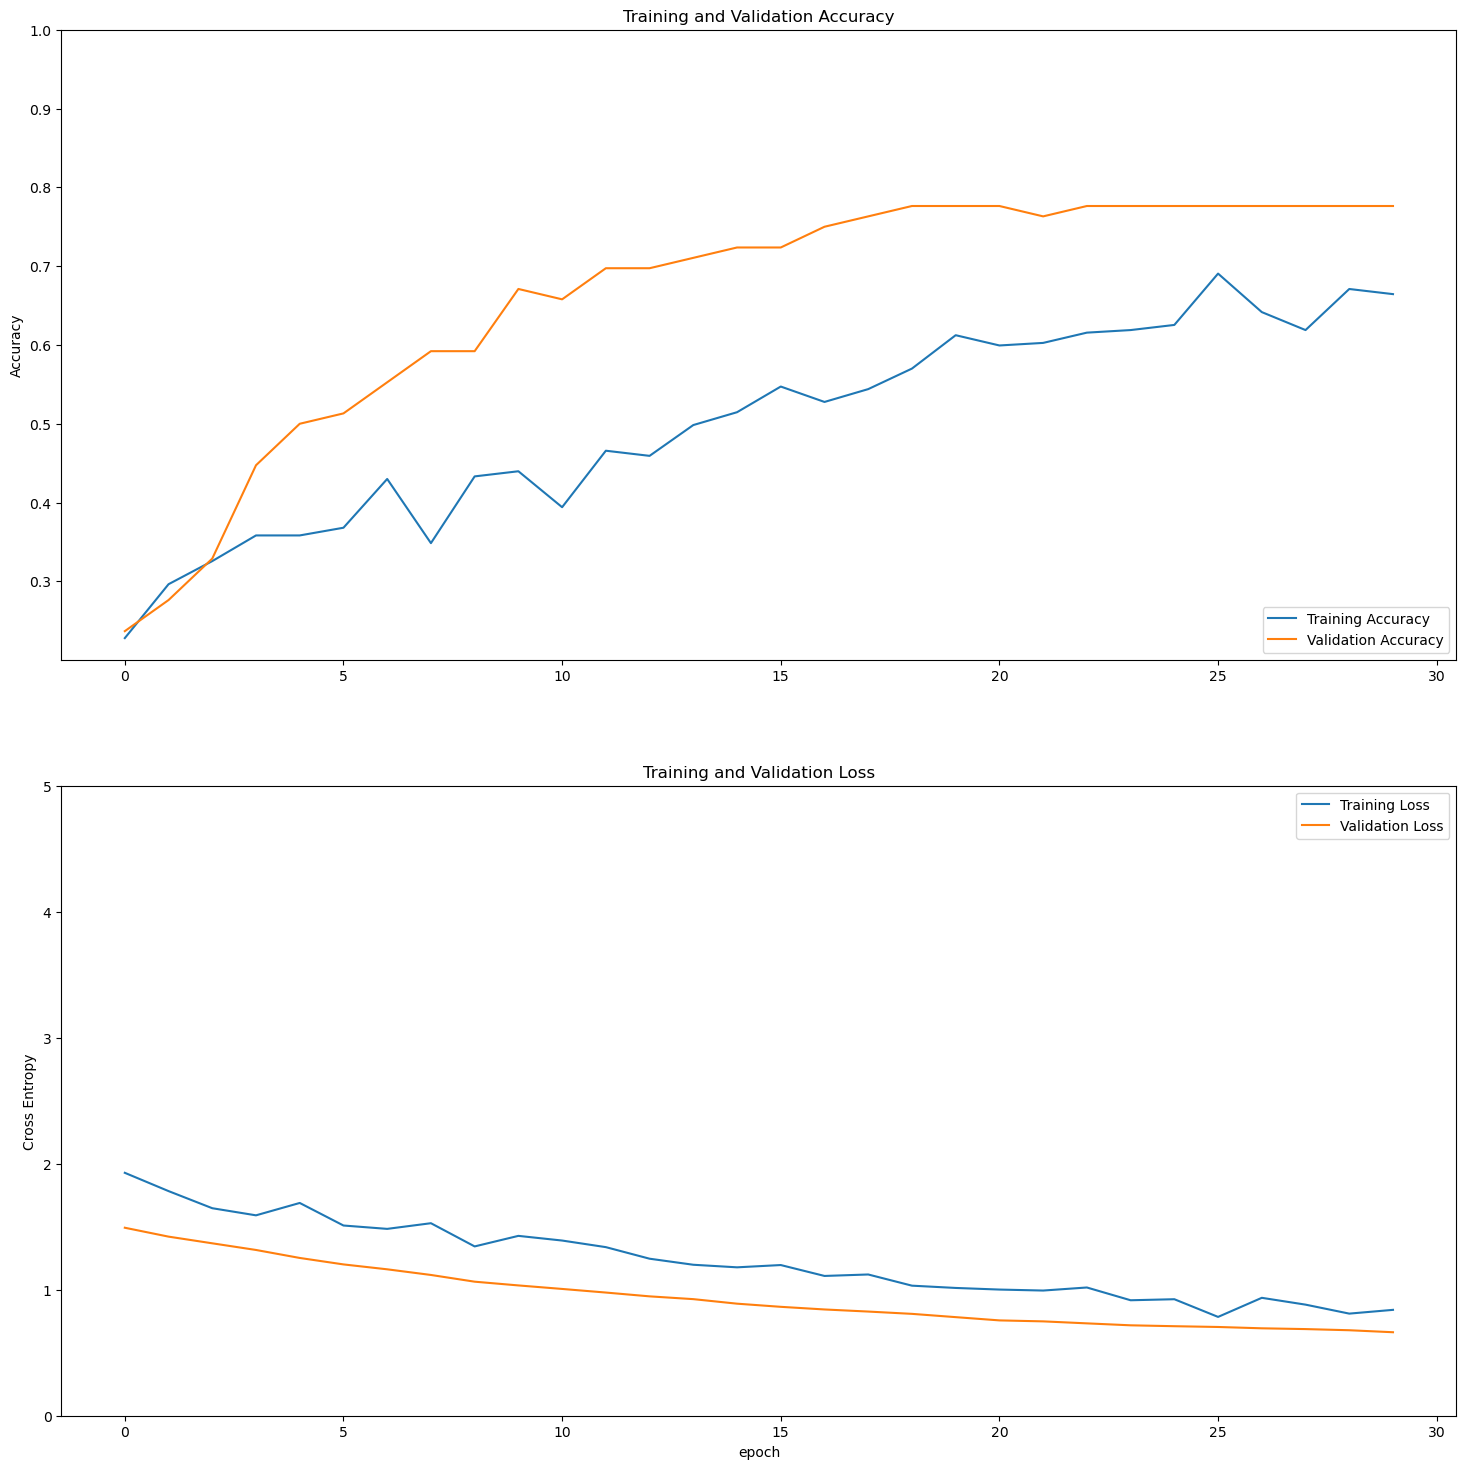

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_freese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


<h4>UN-FREESE</h4>

In [85]:
base_model.trainable = True

In [86]:
print("Aantal layers in het basis model: ", len(base_model.layers))

Aantal layers in het basis model:  154


In [87]:
fine_tune_at = 100

# Freeze alle layers voor 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

<h4>Het model terug samenstellen</h4>

In [88]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [89]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [90]:
len(model.trainable_variables)

56

<h4>Voortzetting Model training, na de Un-Freese</h4>

In [91]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_ds,
                    callbacks=[tensorboard_callback])

Epoch 30/55
20/20 [==============================] - 20s 661ms/step - loss: 0.8281 - accuracy: 0.6873 - val_loss: 0.5245 - val_accuracy: 0.7763
Epoch 31/55
20/20 [==============================] - 13s 638ms/step - loss: 0.7308 - accuracy: 0.7264 - val_loss: 0.5146 - val_accuracy: 0.8026
Epoch 32/55
20/20 [==============================] - 13s 662ms/step - loss: 0.7453 - accuracy: 0.7003 - val_loss: 0.4915 - val_accuracy: 0.8026
Epoch 33/55
20/20 [==============================] - 12s 596ms/step - loss: 0.5933 - accuracy: 0.8078 - val_loss: 0.4549 - val_accuracy: 0.8158
Epoch 34/55
20/20 [==============================] - 13s 628ms/step - loss: 0.6278 - accuracy: 0.7720 - val_loss: 0.4320 - val_accuracy: 0.8289
Epoch 35/55
20/20 [==============================] - 12s 595ms/step - loss: 0.6180 - accuracy: 0.7915 - val_loss: 0.4167 - val_accuracy: 0.8421
Epoch 36/55
20/20 [==============================] - 12s 610ms/step - loss: 0.5005 - accuracy: 0.8078 - val_loss: 0.4308 - val_accuracy:

In [92]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

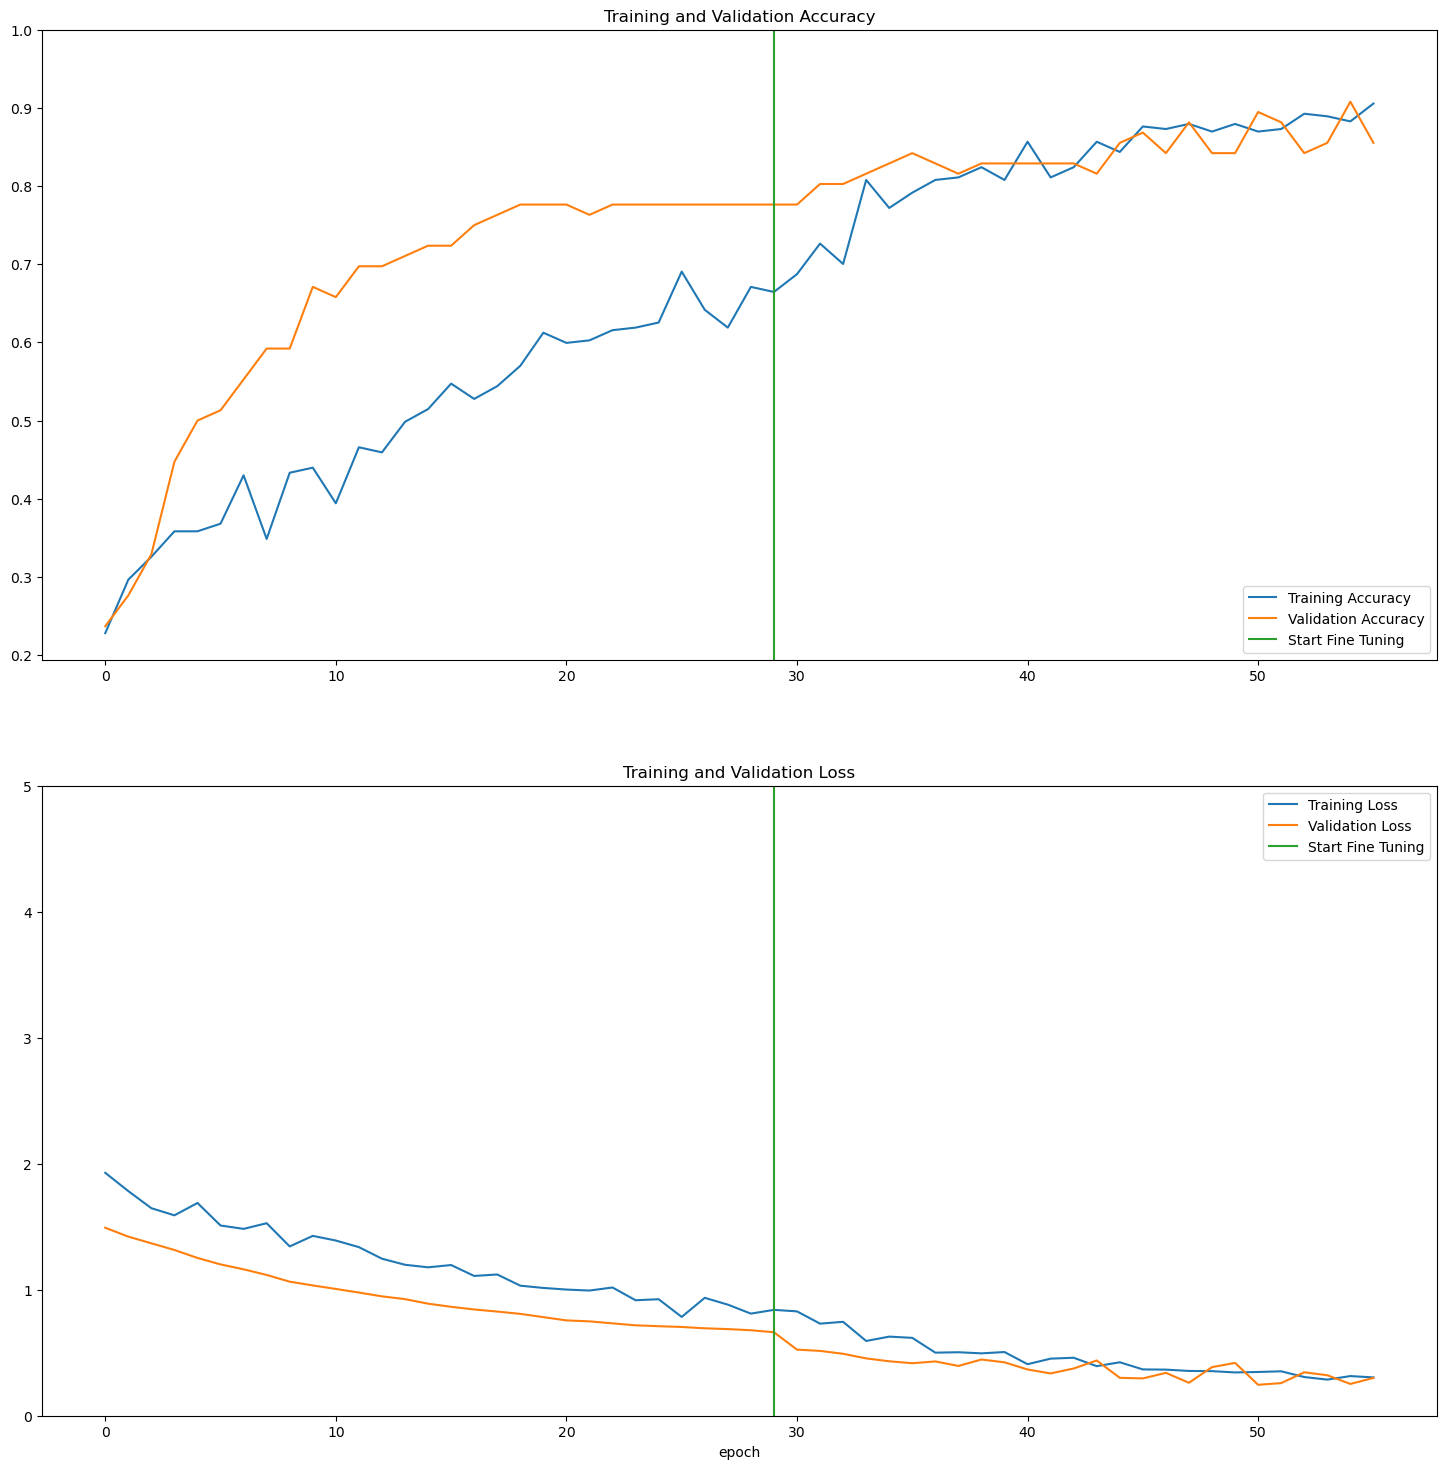

In [93]:
plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0,5.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
plt.savefig('saved_models/tl_mobileNetV2_2/plt_val_acc/tl_UNfreese_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()

In [94]:
model.save('saved_models/tl_mobileNetV2/model/tl_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.h5')

In [95]:
# pickle.dump(model, open('saved_models/tl_mobileNetV2/model/pi_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.pkl', 'wb'))

<h4>Confusion Matrix</h4>

8/8 [==============================] - 3s 260ms/step


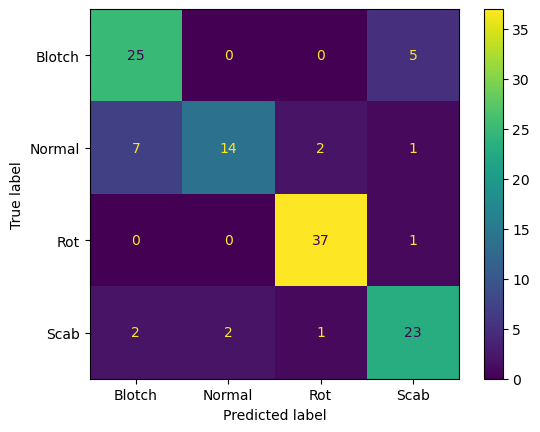

In [96]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
plt.savefig('saved_models/tl_mobileNetV2_2/plt_matrix/tl_matrix_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


###### <h4>Evaluatie en voorspelling</h4>

In [97]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

8/8 [==============================] - 2s 266ms/step - loss: 0.5094 - accuracy: 0.8250
Test accuracy : 0.824999988079071


In [98]:
predictions = model.predict(test_ds).flatten()
# print(predictions)

predictions = tf.nn.softmax(predictions)
# predictions = tf.where(predictions < 0.1, 0, 1)
predictions = tf.math.argmax(predictions)

print('Predictions:\n', predictions.numpy())

8/8 [==============================] - 2s 264ms/step
Predictions:
 250


In [99]:
predictions = model.predict(batch_ds).flatten()
# print(predictions)

predictions = tf.nn.softmax(predictions)
# predictions = tf.where(predictions < 0.1, 0, 1)
predictions = tf.math.argmax(predictions)

print('Predictions:\n', predictions.numpy())

5/5 [==============================] - 2s 304ms/step
Predictions:
 93


Predictions:
 0
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


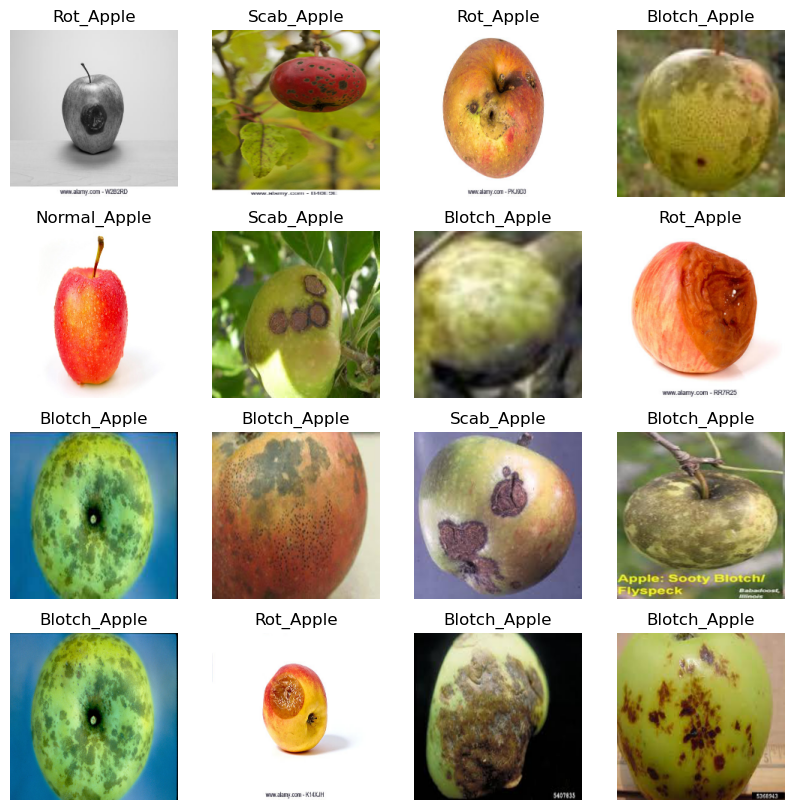

In [100]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.softmax(predictions)
predictions = tf.where(predictions < 0.1, 0, 1)
predictions = tf.math.argmax(predictions)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [101]:
# run Tensorbord
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 15115), started 1 day, 0:38:26 ago. (Use '!kill 15115' to kill it.)